UIDAI Aadhaar Enrolment Data Analysis

Objective:

Analyse Aadhaar enrolment trends across age groups

Identify operational and policy-relevant insights at state, district, and pincode levels

Dataset source: UIDAI Aadhaar Enrolment dataset (Government of India)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as mtick
import numpy as np
base_dir = Path.cwd().parents[0]
raw_dir = base_dir / "data" / "raw" #keep the orignal csv files in the {base_dir}/data/raw
clean_dir = base_dir / "data" / "cleaned" #orignal might be having some duplicated data or typing errors we will fix them in new csvs and put new csvs in (base_dir}/data/cleaned
csv_files = [
    "api_data_aadhar_enrolment_0_500000.csv",
    "api_data_aadhar_enrolment_500000_1000000.csv",
    "api_data_aadhar_enrolment_1000000_1006029.csv"
]

In [4]:
age_cols = ["age_0_5", "age_5_17", "age_18_greater"]

In [5]:
def filter_by_level(df, level, state=None, district=None, pincode=None):
    level = level.strip().lower()

    if level == "national":
        return df

    elif level == "state":
        if not state:
            raise ValueError("State required")

        return df[
            df["state"].astype(str).str.strip().str.lower()
            == state.strip().lower()
        ]

    elif level == "district":
        if not state or not district:
            raise ValueError("State and District required")

        return df[
            (df["state"].astype(str).str.strip().str.lower()
             == state.strip().lower())
            &
            (df["district"].astype(str).str.strip().str.lower()
             .str.contains(district.strip().lower(), na=False))
        ]

    elif level == "pincode":
        if not pincode:
            raise ValueError("Pincode required")

        return df[
            df["pincode"].astype(str).str.strip()
            == str(pincode).strip()
        ]

    else:
        raise ValueError("Invalid level")


### Loading cleaned files

In [6]:
df_clean = pd.concat(
    (pd.read_csv(clean_dir / f) for f in csv_files),
    ignore_index=True
)
df_clean

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,total_enrolments,month,month_order,weekday,weekday_order
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37,109,March,3,Sunday,6
1,2025-03-09,Bihar,Bhagalpur,812005,13,40,18,71,March,3,Sunday,6
2,2025-03-09,Bihar,East Champaran,845304,18,72,12,102,March,3,Sunday,6
3,2025-03-09,Bihar,East Champaran,845418,30,48,10,88,March,3,Sunday,6
4,2025-03-09,Bihar,Madhubani,847108,18,120,22,160,March,3,Sunday,6
...,...,...,...,...,...,...,...,...,...,...,...,...
946623,2025-12-31,West Bengal,Uttar Dinajpur,733156,8,9,0,17,December,12,Wednesday,2
946624,2025-12-31,West Bengal,Uttar Dinajpur,733201,33,26,1,60,December,12,Wednesday,2
946625,2025-12-31,West Bengal,Uttar Dinajpur,733207,22,23,0,45,December,12,Wednesday,2
946626,2025-12-31,West Bengal,Uttar Dinajpur,733212,2,1,0,3,December,12,Wednesday,2


In [7]:
def months_template_df(value_col="total_enrolments"):
    months = pd.DataFrame({
        "month_order": list(range(1,13))
    })
    months["month"] = months["month_order"].apply(lambda m: pd.Timestamp(2025, m, 1).month_name())
    months[value_col] = 0
    return months

In [8]:
def monthly_analysis():
    level = input("Choose level (national/state/district/pincode): ").strip().lower()

    state = district = pincode = None

    if level == "state":
        state = input("Enter State: ")

    elif level == "district":
        state = input("Enter State (required): ")
        district = input("Enter District: ")

    elif level == "pincode":
        pincode = input("Enter Pincode: ")

    df_scope = filter_by_level(df_clean, level, state, district, pincode)

    if df_scope.empty:
        print("No data found.")
        return

    df_scope = df_scope.copy()
    df_scope["date"] = pd.to_datetime(df_scope["date"], errors="coerce")
    df_scope["month"] = df_scope["date"].dt.strftime("%b")
    df_scope["month_order"] = df_scope["date"].dt.month

    agg = (
        df_scope
        .groupby(["month_order", "month"], as_index=False)["total_enrolments"]
        .sum()
        .sort_values("month_order")
    )

    plt.figure(figsize=(9, 4))
    plt.bar(agg["month"], agg["total_enrolments"])
    plt.ylabel("Total Enrolments")
    plt.title("Monthly Enrolments")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

In [9]:
import calendar

def month_daywise_analysis():
    month_raw = input("Enter month number (1–12): ").strip()
    if not month_raw.isdigit():
        print("Invalid month.")
        return

    month_num = int(month_raw)
    if month_num < 1 or month_num > 12:
        print("Month must be between 1 and 12.")
        return

    month_name = calendar.month_name[month_num]

    level = input("Choose level (national/state/district/pincode): ").strip().lower()

    df_scope = df_clean.copy()
    title = f"Day-wise Enrolments (Mon–Sun) — {month_name}"

    if level == "state":
        state = input("Enter State: ").strip()
        df_scope = df_scope[df_scope["state"].str.lower() == state.lower()]
        title += f" — {state}"

    elif level == "district":
        state = input("Enter State (required): ").strip()
        district = input("Enter District: ").strip()
        df_scope = df_scope[
            (df_scope["state"].str.lower() == state.lower()) &
            (df_scope["district"].str.lower() == district.lower())
        ]
        title += f" — {district}, {state}"

    elif level == "pincode":
        pin = input("Enter Pincode: ").strip()
        df_scope = df_scope[df_scope["pincode"].astype(str) == pin]
        title += f" — Pincode {pin}"

    elif level != "national":
        print("Invalid level.")
        return

    if df_scope.empty:
        print("No data found.")
        return

    df_scope = df_scope[df_scope["month_order"] == month_num]

    if df_scope.empty:
        print("No data found for this month.")
        return

    agg = (
        df_scope
        .groupby(["weekday_order", "weekday"], as_index=False)["total_enrolments"]
        .sum()
        .sort_values("weekday_order")
    )

    plt.figure(figsize=(10, 4))
    plt.bar(agg["weekday"], agg["total_enrolments"], width=0.6)
    plt.ylabel("Total Enrolments")
    plt.title(title)
    plt.xticks(rotation=30)
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


In [10]:
def daywise_analysis():
    level = input("Choose level (national/state/district/pincode): ").strip().lower()

    df_scope = df_clean.copy()
    title = "Enrolments by Day of Week (Mon–Sun)"

    if level == "state":
        state = input("Enter State: ").strip()
        df_scope = df_scope[df_scope["state"].str.lower() == state.lower()]
        title += f" — {state}"

    elif level == "district":
        state = input("Enter State (required): ").strip()
        district = input("Enter District: ").strip()
        df_scope = df_scope[
            (df_scope["state"].str.lower() == state.lower()) &
            (df_scope["district"].str.lower() == district.lower())
        ]
        title += f" — {district}, {state}"

    elif level == "pincode":
        pin = input("Enter Pincode: ").strip()
        df_scope = df_scope[df_scope["pincode"].astype(str) == pin]
        title += f" — Pincode {pin}"

    elif level != "national":
        print("Invalid level.")
        return

    if df_scope.empty:
        print("No data found.")
        return

    agg = (
        df_scope
        .groupby(["weekday_order", "weekday"], as_index=False)["total_enrolments"]
        .sum()
        .sort_values("weekday_order")
    )

    plt.figure(figsize=(8, 4))
    plt.bar(agg["weekday"], agg["total_enrolments"], width=0.6)
    plt.ylabel("Total Enrolments")
    plt.title(title)
    plt.xticks(rotation=30)
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

### Aadhar Enrolment across the Months from March to December

In [11]:
monthly_national = (
    df_clean.groupby(["month_order", "month"], as_index=False)["total_enrolments"]
      .sum()
      .sort_values("month_order")
      .drop(columns="month_order")
)
monthly_national.style.hide(axis="index")

month,total_enrolments
March,16582
April,257438
May,183616
June,215734
July,616868
September,1475879
October,817920
November,1092007
December,759658


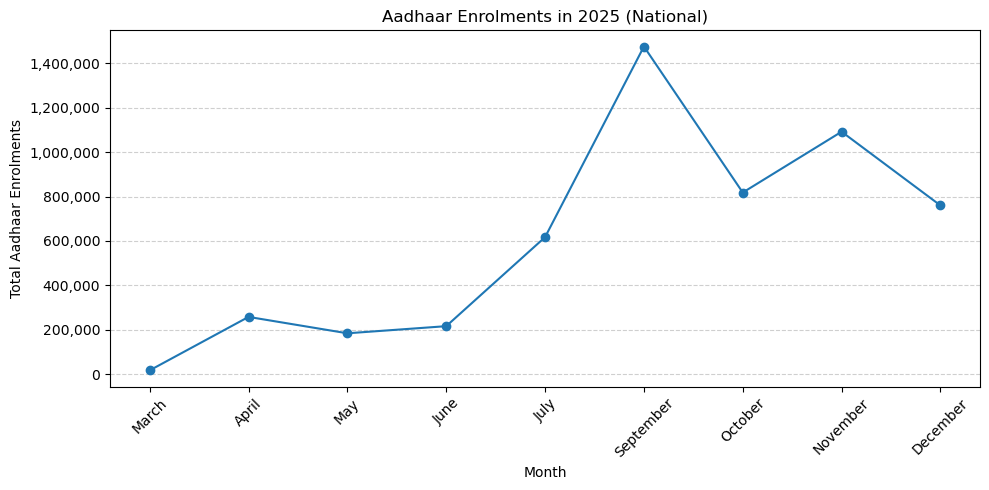

In [12]:
plt.figure(figsize=(10,5))
plt.plot(
    monthly_national["month"].astype(str),
    monthly_national["total_enrolments"],
    marker='o'
)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Total Aadhaar Enrolments")
plt.title("Aadhaar Enrolments in 2025 (National)")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### State-wise Aadhar Enrolment Data

In [13]:
state_age = (
    df_clean.groupby("state")[["age_0_5", "age_5_17", "age_18_greater", "total_enrolments"]]
      .sum()
      .sort_values("total_enrolments", ascending=False) 
)
state_age

,age_0_5,age_5_17,age_18_greater,total_enrolments
state,,,,
Uttar Pradesh,521045,479682,17902,1018629
Bihar,262875,334802,11908,609585
Madhya Pradesh,367990,116381,9599,493970
West Bengal,275420,91410,8510,375340
Maharashtra,278814,82116,8209,369139
Rajasthan,229780,113123,5555,348458
Gujarat,193031,71182,16336,280549
Assam,141235,66085,22877,230197
Karnataka,179262,33863,10110,223235


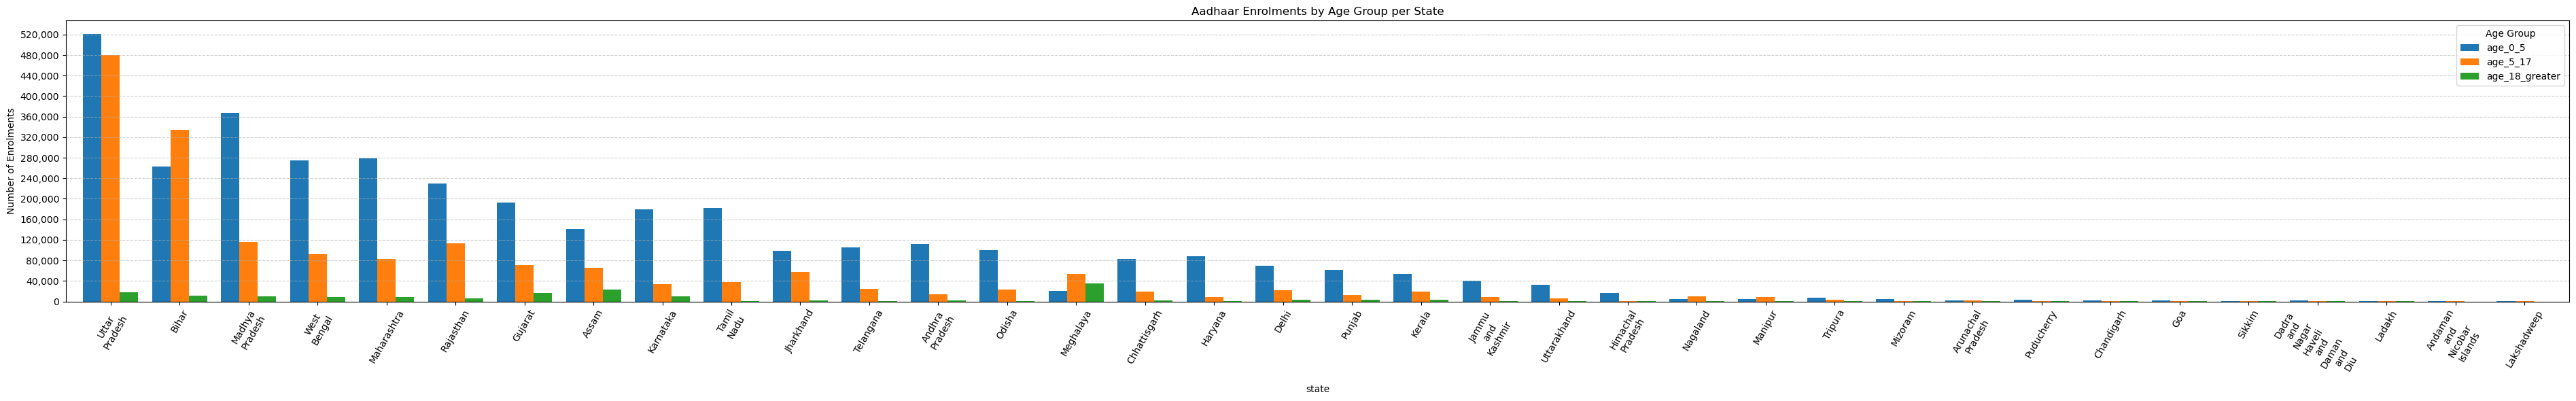

In [14]:
state_age_short = state_age.copy()
state_age_short = state_age_short.sort_values(
    by='total_enrolments',
    ascending=False
)
state_age_short = state_age_short.drop(columns='total_enrolments')
state_age_short.index = state_age_short.index.str.replace(" ", "\n")
state_age_short.plot(
    kind="bar",
    figsize=(38, 6),
    width=0.8
)
plt.ylabel("Number of Enrolments")
plt.title("Aadhaar Enrolments by Age Group per State")
plt.xticks(rotation=60)
plt.gca().yaxis.set_major_formatter(
    mtick.StrMethodFormatter('{x:,.0f}')
)
plt.legend(title="Age Group")
plt.gca().yaxis.set_major_locator(
    mtick.MaxNLocator(nbins=15)
)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Age-wise percentage of the 3 age groups across different states

In [15]:
state_age_ratios = state_age[age_cols].div(
    state_age[age_cols].sum(axis=1),
    axis=0
)
state_age_ratios

,age_0_5,age_5_17,age_18_greater
state,,,
Uttar Pradesh,0.511516,0.470909,0.017575
Bihar,0.431236,0.549229,0.019535
Madhya Pradesh,0.744964,0.235603,0.019432
West Bengal,0.733788,0.243539,0.022673
Maharashtra,0.755309,0.222453,0.022238
Rajasthan,0.659419,0.324639,0.015942
Gujarat,0.688047,0.253724,0.058229
Assam,0.613540,0.287080,0.099380
Karnataka,0.803019,0.151692,0.045289


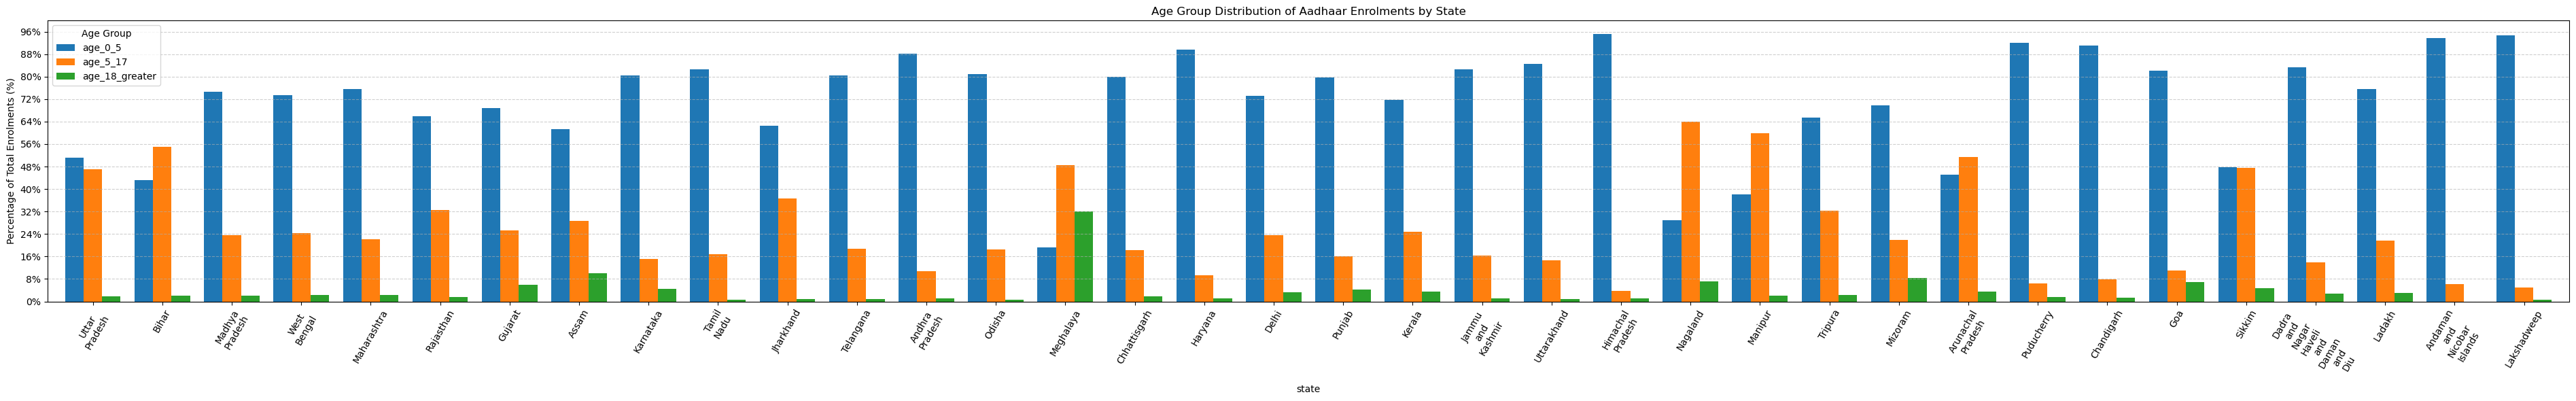

In [16]:
state_age_pct = state_age.copy()
state_age_pct = state_age_pct.sort_values(
    by='total_enrolments',
    ascending=False
)
state_age_pct = state_age_pct.drop(columns='total_enrolments')
state_age_pct = state_age_pct.div(
    state_age_pct.sum(axis=1),
    axis=0
) * 100
state_age_pct.index = state_age_pct.index.str.replace(" ", "\n")
state_age_pct.plot(
    kind="bar",
    figsize=(38, 6),
    width=0.8
)
plt.ylabel("Percentage of Total Enrolments (%)")
plt.title("Age Group Distribution of Aadhaar Enrolments by State")
plt.xticks(rotation=60)
plt.gca().yaxis.set_major_formatter(
    mtick.StrMethodFormatter('{x:.0f}%')
)
plt.gca().yaxis.set_major_locator(
    mtick.MaxNLocator(nbins=15)
)
plt.legend(title="Age Group")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### Total Enrolments across states

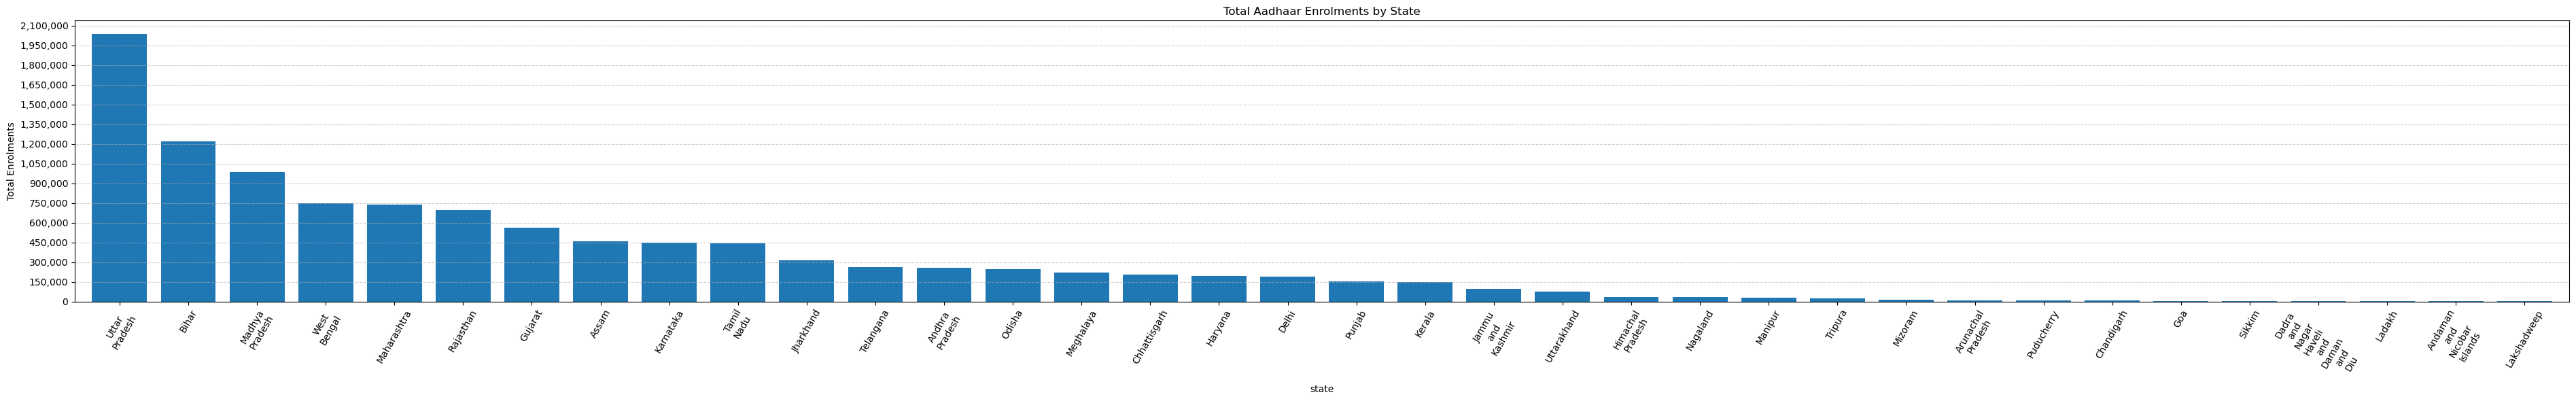

In [17]:
state_total = state_age.sum(axis=1)
state_total_short = state_total.copy()
state_total_short.index = state_total_short.index.str.replace(" ", "\n")
state_total_short.plot(
    kind="bar",
    figsize=(38, 6),
    width=0.8
)
plt.ylabel("Total Enrolments")
plt.title("Total Aadhaar Enrolments by State")
plt.xticks(rotation=60)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=15))
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### Enrolments in different months in India

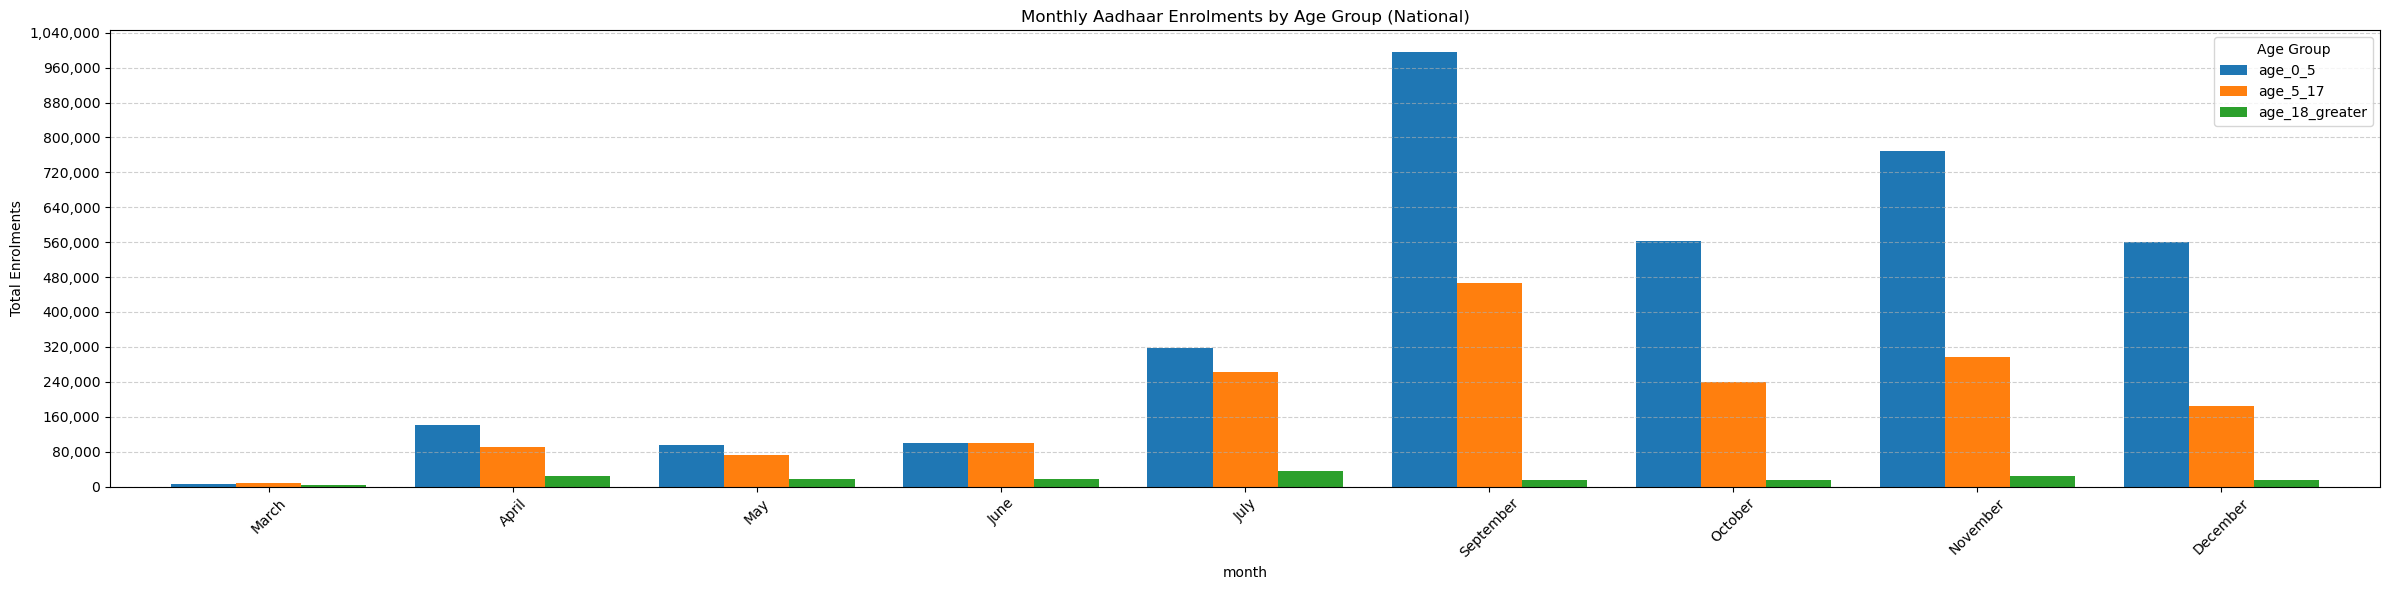

In [18]:
monthly_age = (
    df_clean
    .groupby(["month_order", "month"], as_index=False)[age_cols]
    .sum()
    .sort_values("month_order")
)
monthly_age.index = monthly_age["month"].astype(str)
monthly_age[age_cols].plot(kind="bar", figsize=(24,6), width=0.8)


plt.ylabel("Total Enrolments")
plt.title("Monthly Aadhaar Enrolments by Age Group (National)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=15))
plt.legend(title="Age Group")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### top 10 states by total enrolments

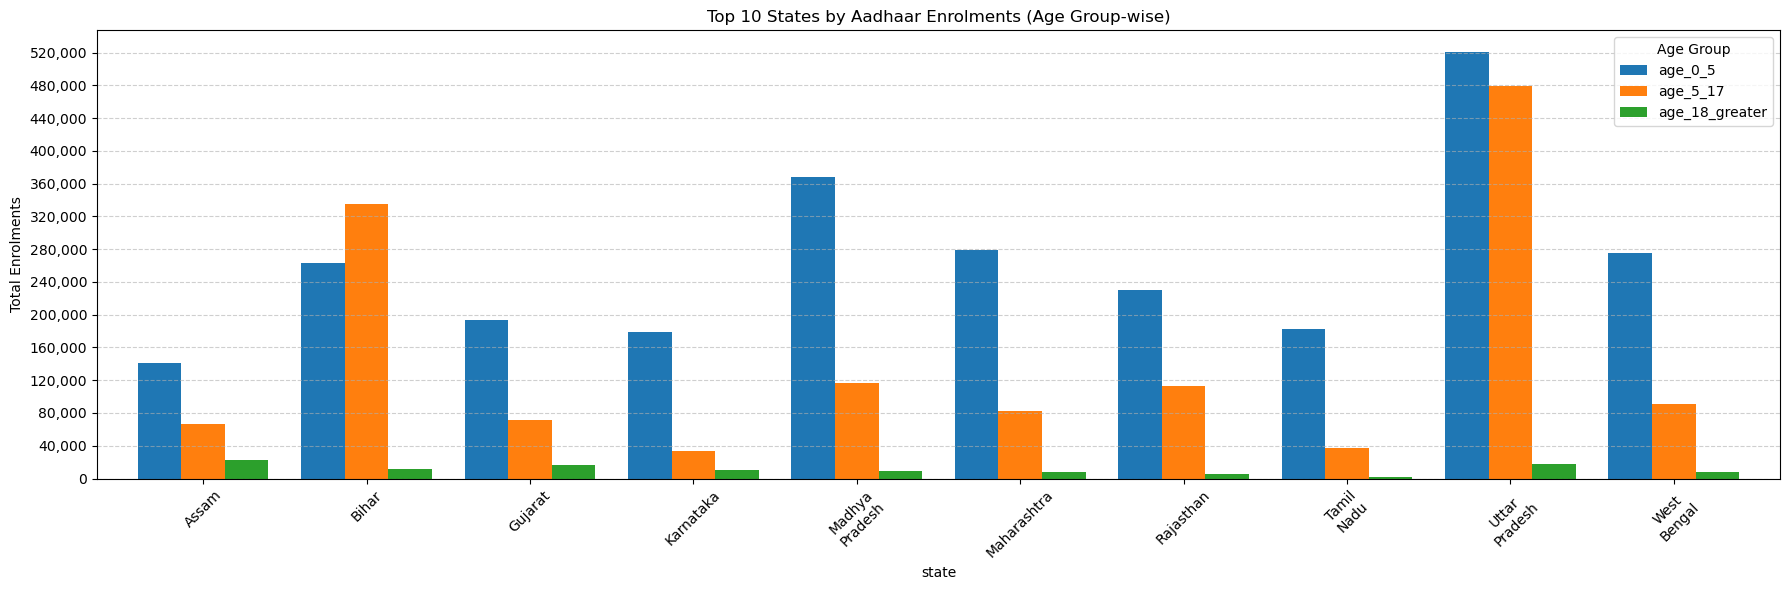

In [19]:

top_states = (
    df_clean.groupby("state")["total_enrolments"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

top_state_age = (
    df_clean[df_clean["state"].isin(top_states)]
    .groupby("state")[age_cols]
    .sum()
)

# shorten state names
top_state_age_short = top_state_age.copy()
top_state_age_short.index = top_state_age_short.index.str.replace(" ", "\n")

top_state_age_short.plot(
    kind="bar",
    figsize=(18, 6),
    width=0.8
)

plt.ylabel("Total Enrolments")
plt.title("Top 10 States by Aadhaar Enrolments (Age Group-wise)")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=15))
plt.legend(title="Age Group")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [20]:
_states = sorted(df_clean['state'].dropna().unique().tolist())
_districts = sorted(df_clean['district'].dropna().unique().tolist())
_pincodes = sorted(df_clean['pincode'].dropna().unique().astype(str).tolist())

def find_state(name):
    # case-insensitive
    name_lower = name.strip().lower()
    for s in _states:
        if s.lower() == name_lower:
            return s
def find_district(name):
    name_lower = name.strip().lower()
    for d in _districts:
        if d.lower() == name_lower:
            return d
    return None
def find_pincode(code):
    c = str(code).strip()
    return c if c in _pincodes else None

In [21]:
def age_wise_analysis():
    # ask for state until non-empty
    while True:
        state_name = input("Enter State name (case-insensitive) [required]: ").strip()
        if state_name != "":
            break
        print("State is required for this analysis. Please enter a state name.")
    state_mask = df_clean["state"].astype(str).str.lower() == state_name.lower()
    if not state_mask.any():
        print("No data found for this state.")
        return
    # district optional
    district_name = input("Enter District name (leave blank for state-level): ").strip()
    if district_name == "":
        # STATE LEVEL
        state_df = df_clean[state_mask]
        # aggregate age groups
        age_df = state_df[age_cols].sum().reset_index()
        age_df.columns = ["Age Group", "Total Enrolments"]
        age_df["Age Group"] = age_df["Age Group"].replace({
            "age_0_5": "0–5",
            "age_5_17": "5–17",
            "age_18_greater": "18+"
        })
        age_df = age_df.sort_values("Total Enrolments", ascending=False)
        plt.figure(figsize=(8,5))
        plt.bar(age_df["Age Group"], age_df["Total Enrolments"], width=0.6)
        plt.xlabel("Age Group")
        plt.ylabel("Total Enrolments")
        plt.title(f"Aadhaar Enrolments by Age Group — {state_name}")
        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=12))
        plt.tight_layout()
        plt.show()

    else:
        district_mask = (df_clean["state"].astype(str).str.lower() == state_name.lower()) & \
                        (df_clean["district"].astype(str).str.lower() == district_name.lower())

        if not district_mask.any():
            print("No data found for this state/district.")
            return

        district_df = df_clean[district_mask]

        age_df = district_df[age_cols].sum().reset_index()
        age_df.columns = ["Age Group", "Total Enrolments"]
        age_df["Age Group"] = age_df["Age Group"].replace({
            "age_0_5": "0–5",
            "age_5_17": "5–17",
            "age_18_greater": "18+"
        })

        age_df = age_df.sort_values("Total Enrolments", ascending=False)

        plt.figure(figsize=(8,5))
        plt.bar(age_df["Age Group"], age_df["Total Enrolments"], width=0.6)
        plt.xlabel("Age Group")
        plt.ylabel("Total Enrolments")
        plt.title(f"Aadhaar Enrolments by Age Group — {district_name}, {state_name}")
        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(nbins=12))
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()

In [22]:
def enrolment_trend_analysis():
    raw = input("Enter District name OR Pincode: ").strip()
    if raw.isdigit():
        df_scope = df_clean[
            df_clean["pincode"].astype(str).str.strip() == raw
        ]

        if df_scope.empty:
            print("No data found for this pincode.")
            return

        total = df_scope["total_enrolments"].sum()

        plt.figure(figsize=(6, 4))
        plt.bar(["Total Enrolments"], [total], width=0.5)
        plt.ylabel("Total Enrolments")
        plt.title(f"Aadhaar Enrolments — Pincode {raw}")
        plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()
        return
    state = input("Enter State (required for district analysis): ").strip()

    df_scope = df_clean[
        (df_clean["state"].astype(str).str.strip().str.lower()
         == state.lower())
        &
        (df_clean["district"].astype(str).str.strip().str.lower()
         .str.contains(raw.lower(), na=False))
    ]

    if df_scope.empty:
        print("No data found for this state/district.")
        return

    total = df_scope["total_enrolments"].sum()

    plt.figure(figsize=(6, 4))
    plt.bar(["Total Enrolments"], [total], width=0.5)
    plt.ylabel("Total Enrolments")
    plt.title(f"Aadhaar Enrolments — {raw}, {state}")
    plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

## Comparision of Aadhar enrolments in different age groups for input State or District

Enter State name (case-insensitive) [required]:  maharashtra
Enter District name (leave blank for state-level):  pune


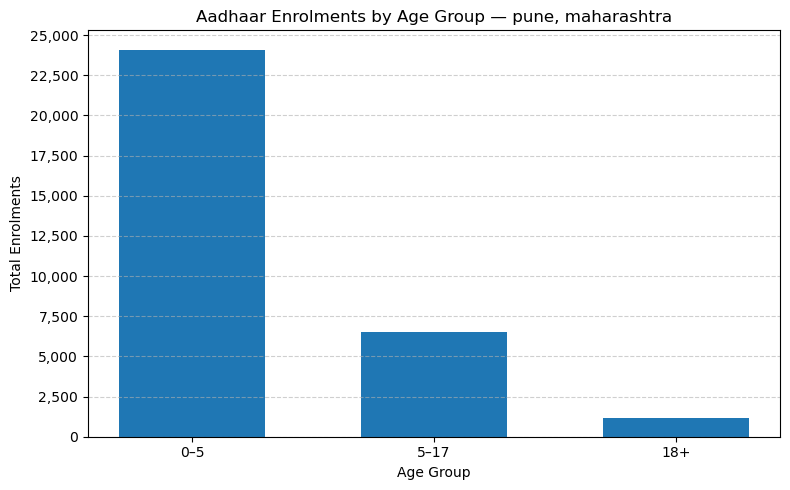

In [21]:
age_wise_analysis()

Enter State name (case-insensitive) [required]:  madhya pradesh
Enter District name (leave blank for state-level):  


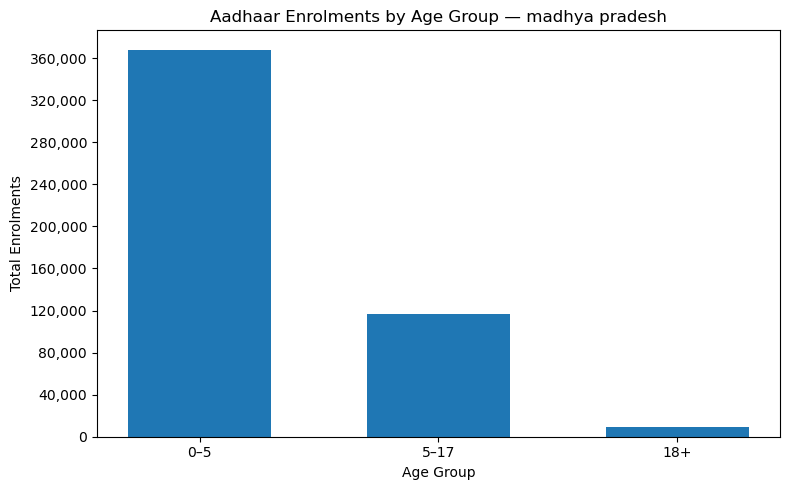

In [22]:
age_wise_analysis()

## Total enrolements in input District or Pin-code

Enter District name OR Pincode:  nagpur
Enter State (required for district analysis):  maharashtra


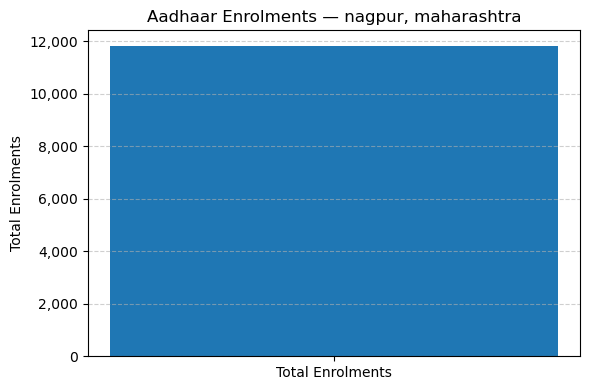

In [23]:
enrolment_trend_analysis()

Enter District name OR Pincode:  440014


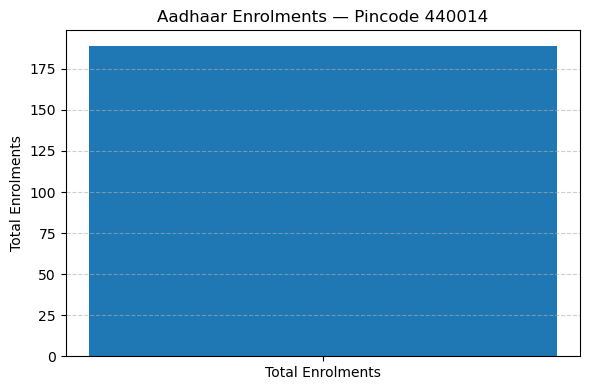

In [24]:
enrolment_trend_analysis()

## Comparison of Enrolments in different days

Choose level (national/state/district/pincode):  national


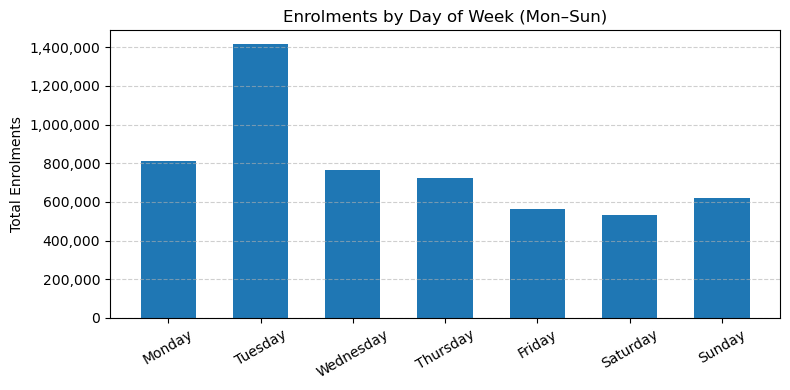

In [36]:
daywise_analysis()

Choose level (national/state/district/pincode):  state
Enter State:  maharashtra


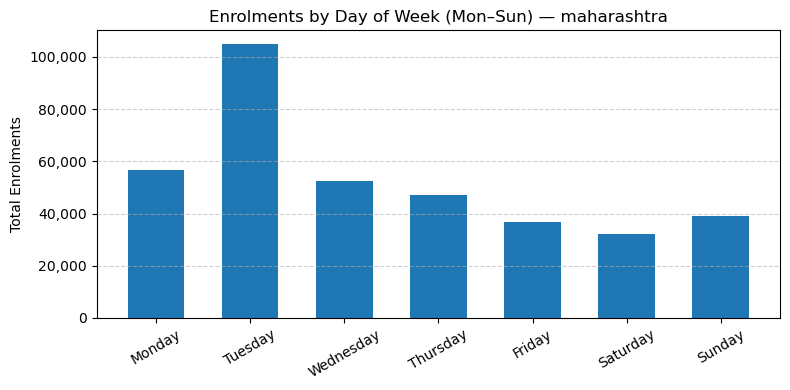

In [37]:
daywise_analysis()

Choose level (national/state/district/pincode):  district
Enter State (required):  maharashtra
Enter District:  nagpur


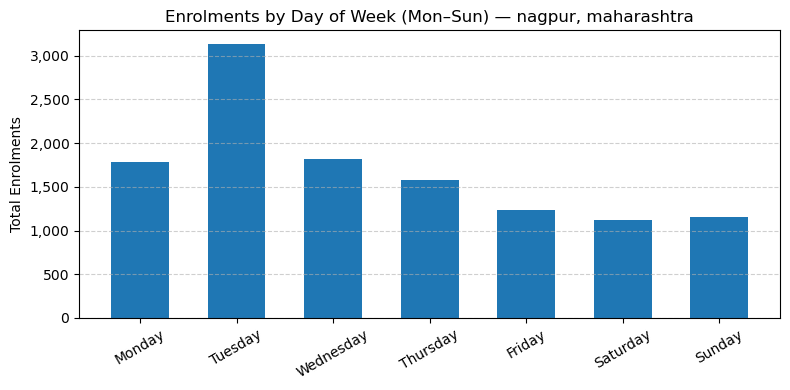

In [40]:
daywise_analysis()

Choose level (national/state/district/pincode):  pincode
Enter Pincode:  440001


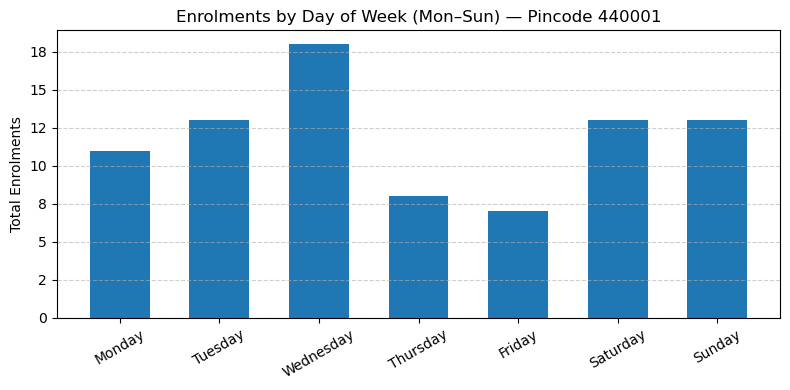

In [41]:
daywise_analysis()

## Comparison of Enrolments different days in input month

Enter month number (1–12):  9
Choose level (national/state/district/pincode):  national


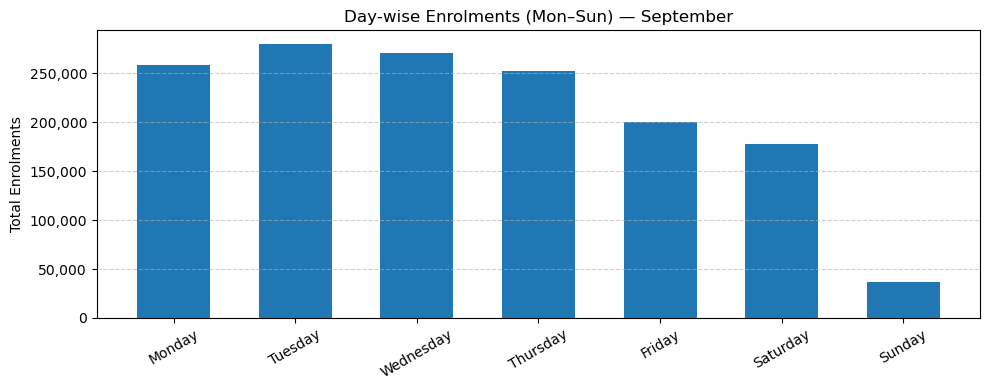

In [44]:
month_daywise_analysis()

Enter month number (1–12):  9
Choose level (national/state/district/pincode):  state
Enter State:  maharashtra


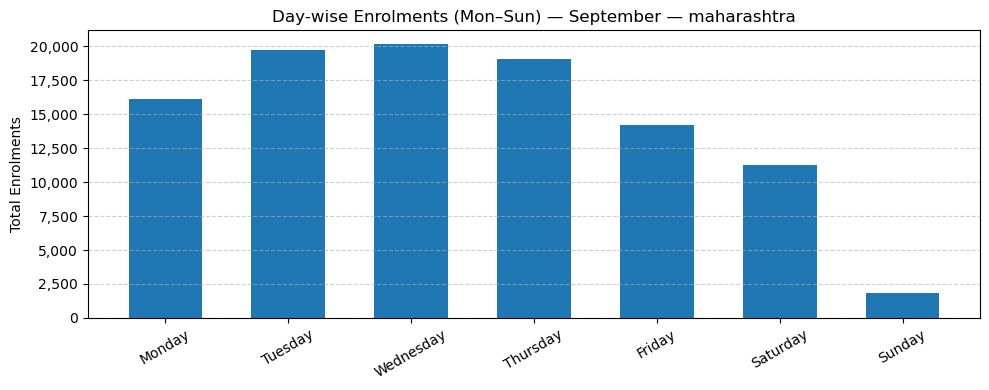

In [47]:
month_daywise_analysis()

Enter month number (1–12):  9
Choose level (national/state/district/pincode):  district
Enter State (required):  maharashtra
Enter District:  nagpur


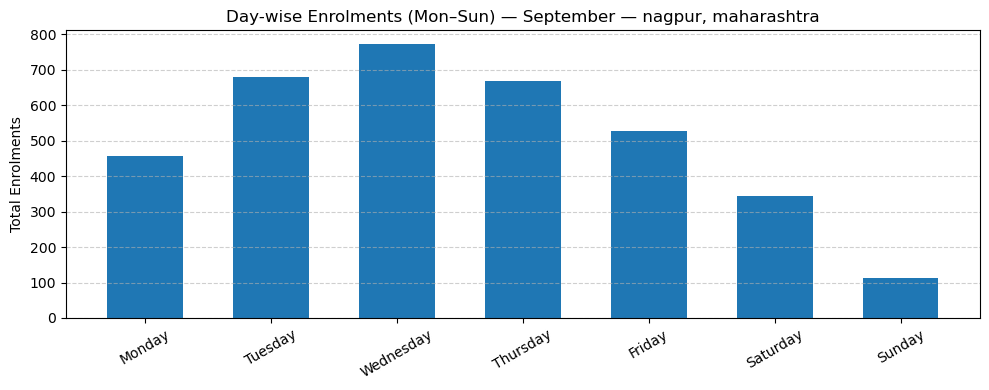

In [46]:
month_daywise_analysis()

Enter month number (1–12):  9
Choose level (national/state/district/pincode):  pincode
Enter Pincode:  440014


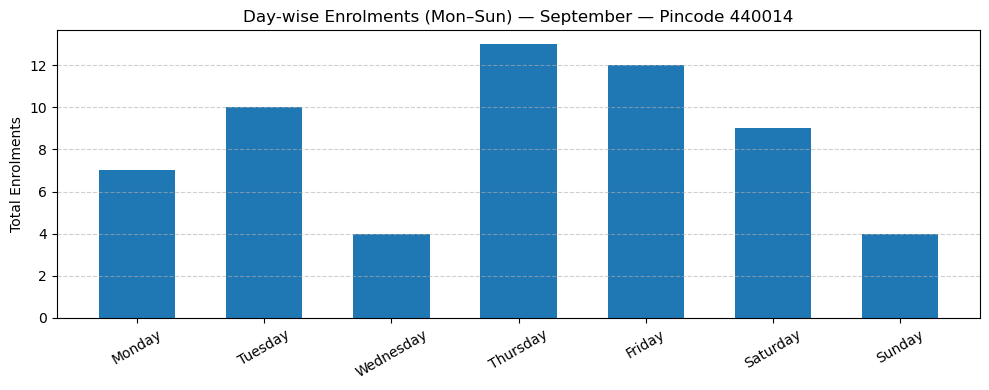

In [48]:
month_daywise_analysis()

# Research Insights

## 1. Low 0_5 age enrolment ratio in Meghalaya

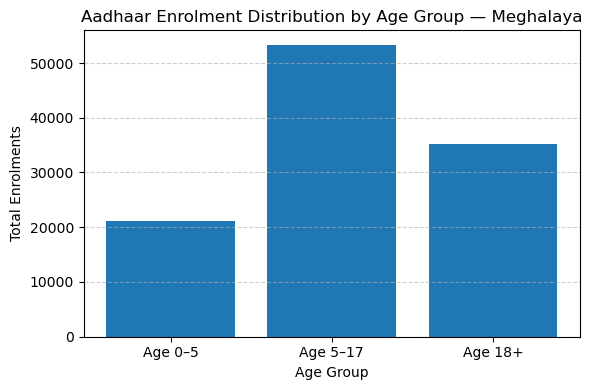

In [49]:
meghalaya = (
    df_clean[df_clean['state'] == 'Meghalaya']
    [['age_0_5', 'age_5_17', 'age_18_greater']]
    .sum()
)
plt.figure(figsize=(6,4))
plt.bar(
    ['Age 0–5', 'Age 5–17', 'Age 18+'],
    meghalaya.values
)
plt.title('Aadhaar Enrolment Distribution by Age Group — Meghalaya')
plt.ylabel('Total Enrolments')
plt.xlabel('Age Group')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 2. top 10 states with highest adult enrolment ratio

In [50]:
district_age = (
    df_clean
    .groupby(["state", "district"], as_index=False)
    [["age_0_5", "age_5_17", "age_18_greater"]]
    .sum()
)

district_age["total"] = (
    district_age["age_0_5"] +
    district_age["age_5_17"] +
    district_age["age_18_greater"]
)

district_age["adult_ratio"] = district_age["age_18_greater"] / district_age["total"]

district_age.sort_values("adult_ratio", ascending=False).head(10)

,state,district,age_0_5,age_5_17,age_18_greater,total,adult_ratio
476,Meghalaya,Eastern West Khasi Hills,3,226,589,818,0.720049
488,Mizoram,Khawzawl,5,7,24,36,0.666667
612,Sikkim,Namchi,3,7,14,24,0.583333
494,Mizoram,Saitual,2,3,7,12,0.583333
478,Meghalaya,Ri Bhoi,1338,4598,3372,9308,0.362269
474,Meghalaya,East Jaintia Hills,983,2354,1796,5133,0.349893
475,Meghalaya,East Khasi Hills,4258,14606,9948,28812,0.345273
484,Meghalaya,West Khasi Hills,2410,8178,5310,15898,0.334004
47,Arunachal Pradesh,Leparada,0,2,1,3,0.333333
611,Sikkim,Mangan,0,2,1,3,0.333333
